**Tasks:**  
1. Load and clean scraped text: Import the text, convert it to lowercase, remove punctuation and stop words (using nltk).  
2. Tokenize and Analyze: Split the text into words and calculate word frequencies.  
3. Visualize Results:  
   (a) create a bar chart of the top 10 most frequent words.  
   (b) Optionally, generate a word cloud.

In [145]:
import os
import pandas as pd
import re
from pathlib import Path
from datetime import datetime
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import nltk.tokenize.punkt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.tokenize import word_tokenize

In [4]:
# Set paths
code_dir = Path().resolve()
base_dir = Path().resolve().parent
output_dir = base_dir / "output"

In [6]:
print(f"Repo root: {base_dir} \nCode: {code_dir} \nOutput: {output_dir}")

Repo root: /Users/sunny/Documents/GitHub/nlp-analysis 
Code: /Users/sunny/Documents/GitHub/nlp-analysis/code 
Output: /Users/sunny/Documents/GitHub/nlp-analysis/output


In [8]:
# Load scraped data

In [10]:
guardian_relationships = pd.read_csv(output_dir / "guardian_relationships_articles.csv")

In [12]:
guardian_relationships.head()

,title,link,date,text
0,Going boysober: the women who turned to celiba...,https://www.theguardian.com/lifeandstyle/2024/...,2024-12-30 14:00:00,Some call it “boysober”. Others take inspirati...
1,"We opened up our marriage, but now I feel aban...",https://www.theguardian.com/lifeandstyle/2024/...,2024-12-29 06:00:00,: The open relationship you and your wife agre...
2,"Six hours, six weddings and a schnauzer: insid...",https://www.theguardian.com/lifeandstyle/2024/...,2024-12-28 19:00:00,"It’s 11 am on a Sunday in Unexpected Guest, on..."
3,Blind date: ‘The glare of the Christmas lights...,https://www.theguardian.com/lifeandstyle/2024/...,2024-12-28 06:00:00,To meet someone intelligent that I could have ...
4,My son’s girlfriend has taken over his life an...,https://www.theguardian.com/lifeandstyle/2024/...,2024-12-27 14:30:00,I do understand your worry. But what is it abo...


In [14]:
# Check missing?
guardian_relationships.notna().sum()  # 27 missings for text out of 1980 articles - can safely drop

title    1980
link     1980
date     1975
text     1953
dtype: int64

In [ ]:
for link in guardian_relationships.loc[guardian_relationships["text"].isna(), "link"]:
    #print(link)

# All the missing entries are mostly podcasts, a few cartoons, and a few picture galleries. So can be dropped.

In [16]:
guardian_relationships = guardian_relationships[~guardian_relationships["text"].isna()]

In [18]:
guardian_relationships["date"] = pd.to_datetime(guardian_relationships["date"])

In [20]:
# Step 1: Preprocess the text (convert to lowercase to ensure case-insensitive matching)
guardian_relationships["processed_text"] = guardian_relationships["text"].str.lower()

In [195]:
# Step 2: Count occurrences of the word "situationship" in each article
guardian_relationships["word_count"] = guardian_relationships["processed_text"].str.count(r"\bsituationships?\'?s?\b")
#guardian_relationships["word_count"] = guardian_relationships["processed_text"].str.count(r"\binferno\b")

In [197]:
# Step 3: Group by a broader time unit (e.g., monthly)
word_frequency = guardian_relationships.groupby(guardian_relationships["date"].dt.to_period("M"))["word_count"].sum().reset_index()
word_frequency["date"] = word_frequency["date"].dt.to_timestamp()

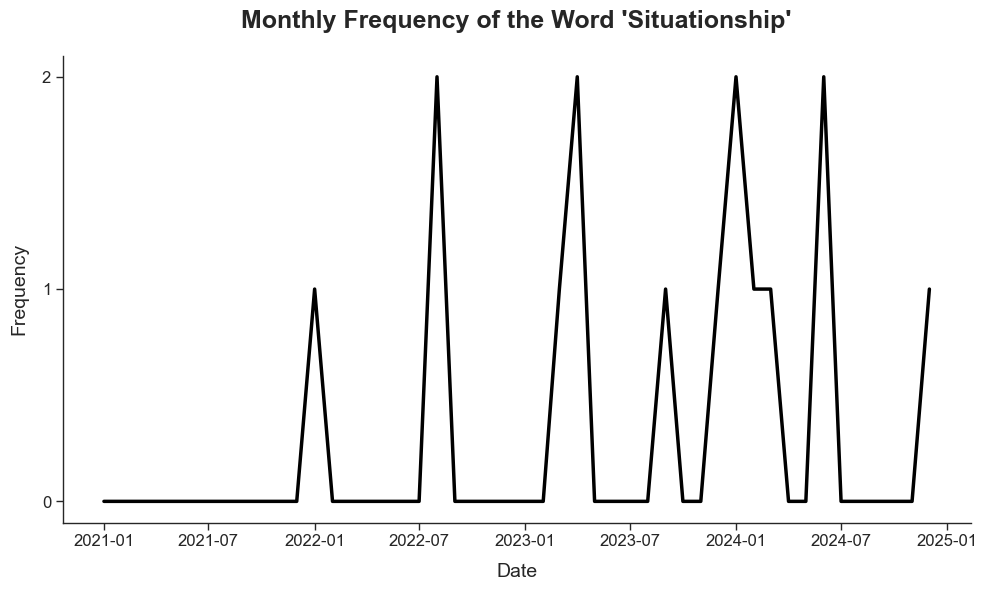

In [217]:
# Set Seaborn theme for a clean, professional look
sns.set_theme(style="ticks", context="paper")

# Create the figure and axes
plt.figure(figsize=(10, 6))

# Plot the time series
sns.lineplot(data=word_frequency, x="date", y="word_count", marker=None, label="Word Frequency", color="black", linewidth=2.5, legend=False)
sns.despine()

# Customizations
plt.title("Monthly Frequency of the Word 'Situationship'", fontsize=18, weight="bold", pad=20)
plt.xlabel("Date", fontsize=14, labelpad=10)
plt.ylabel("Frequency", fontsize=14, labelpad=10)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(ticks=[0,1,2], fontsize=12)
plt.tight_layout()

# Save the plot as a high-quality image (optional)
plt.savefig(output_dir/"word_frequency_situationships.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


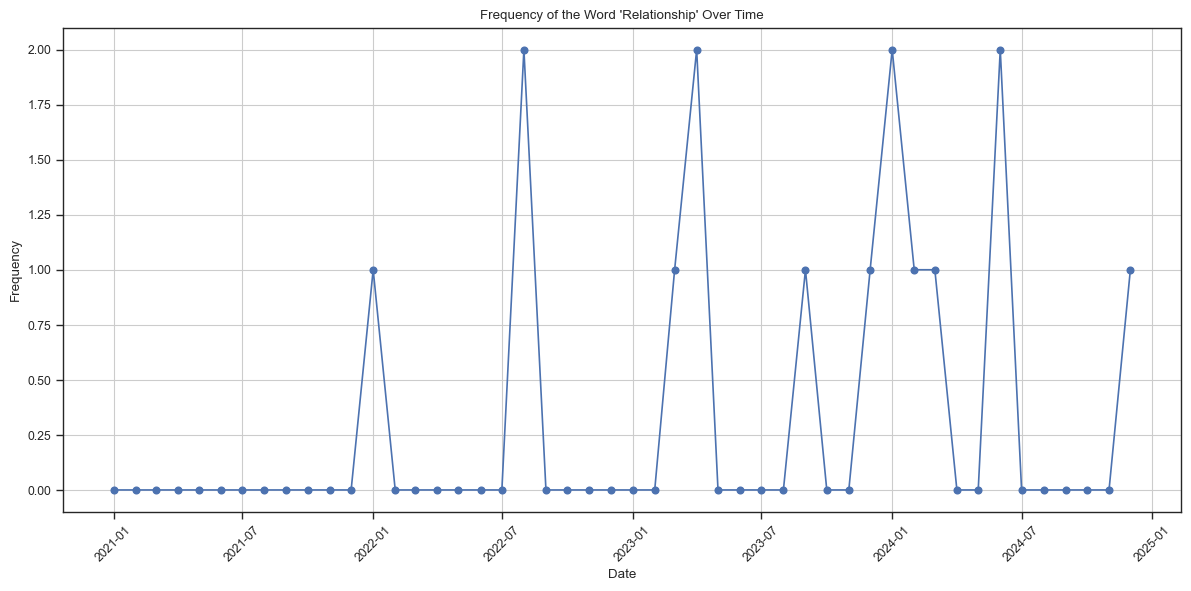

In [166]:
# Step 5: Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(word_frequency["date"], word_frequency["word_count"], marker="o", linestyle="-", color="b")
plt.title("Frequency of the Word 'Relationship' Over Time")
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Combine all articles into a single string
all_text = " ".join(guardian_relationships_clean["text"].tolist())

In [ ]:
# Ensure NLTK stopwords are downloaded
nltk.download("stopwords")
nltk.download("punkt_tab")

# Set up stop words
stop_words = set(stopwords.words("english"))

In [ ]:
# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    stopwords=stop_words,
    max_words=50,  # Limit to the top 100 words
    colormap="viridis"  # Change colormap if desired
).generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Remove axes
plt.show()

In [ ]:
# Topic modelling

In [ ]:
# Preprocess the text
def preprocess(text):
    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [word for word in tokens if word.isalpha()]  # Keep alphabetic tokens only
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    return " ".join(tokens)

# Apply preprocessing to all article text
guardian_relationships_no_na = guardian_relationships[guardian_relationships["text"].notna()].copy()
guardian_relationships_no_na["processed_text"] = guardian_relationships_no_na["text"].apply(preprocess)

# Convert text to a document-term matrix
vectorizer = CountVectorizer(max_features=1000, stop_words="english")  # Limit to 1000 features
dtm = vectorizer.fit_transform(guardian_relationships_no_na["processed_text"])

# Apply LDA
lda = LatentDirichletAllocation(n_components=3, random_state=42)  # Set 5 topics
lda.fit(dtm)

# Display topics
for i, topic in enumerate(lda.components_):
    top_words = [vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-5:]]  # Top 10 words
    print(f"Topic {i+1}: {", ".join(top_words)}")
